<img src="https://cybersecurity-excellence-awards.com/wp-content/uploads/2017/06/366812.png">

<h1><center>Darwin Normal Behavior Modeling (NBM) Example </center></h1>

Prior to getting started, there are a few things you want to do:
1. Set the dataset path.
2. Enter your username and password to ensure that you're able to log in successfully

Once you're up and running, here are a few things to be mindful of:
1. For every run, look up the job status (i.e. requested, failed, running, completed) and wait for job to complete before proceeding. 
2. If you're not satisfied with your model and think that Darwin can do better by exploring a larger search space, use the resume function.

## Import libraries

In [58]:
# Import necessary libraries
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import Image
from time import sleep
import os
import numpy as np
from sklearn.metrics import r2_score

from amb_sdk.sdk import DarwinSdk

## Setup

Register a username and password with Darwin using your API key. <br>**You will have to do this only once.**<br> Fill in api_key, api_password, username, password & email

In [ ]:
# Only run if username is not registered
api_key = ''
api_password = ''
ds = DarwinSdk()
status, msg = ds.auth_login(api_password, api_key)
if not status:
    print(msg)
status, msg = ds.auth_register_user('username', 'password', 'email')
if not status:
    print(msg)

**Login to Darwin**<br>
Enter your registered username and password below to login to Darwin.

In [59]:
# Login
ds = DarwinSdk()
ds.set_url('https://darwin-api.sparkcognition.com/v1/')
status, msg = ds.auth_login_user('username', 'password')
if not status:
    print(msg)

**Data Path** <br>
In the cell below, set the path to your dataset, the default is Darwin's example datasets

In [60]:
path = '.'

## Data Upload

**Read dataset and view a file snippet**

After setting up the dataset path, the next step is to upload the dataset from your local device to the server. <br> In the cell below, you need to specify the dataset_name if you want to use your own data.

In [61]:
dataset_name = 'wind_turbine.csv'
df = pd.read_csv(os.path.join(path, dataset_name))
df.head()

,timestamp,yaw_direction,ctrl_top_temp,vcn,transformer_a_tmp,power,gen_phc_temp,freq,gen_bearing_temp,gen_slip_temp,...,wind_speed,hydro_temp,gbx_bearing_temp,blade_angle,ambient_temp,ica,set_power,gen_phb_temp,pex,ctrl_hub_temp
0,9/1/14 0:10,274.7,26.0,399.5,75.0,1782.8,86.0,59.99,57.0,999.0,...,12.9,47.0,66.0,4.2,20.0,1510.6,1800.0,86.0,1773.0,27.0
1,9/1/14 0:20,269.9,26.0,402.2,70.0,1527.1,86.0,59.99,58.0,999.0,...,11.2,47.0,66.0,-1.3,19.0,1278.5,1800.0,86.0,1446.0,27.0
2,9/1/14 0:30,271.8,26.0,400.6,66.0,1664.7,85.0,59.99,58.0,999.0,...,12.1,47.0,66.0,1.9,20.0,1404.8,1800.0,85.0,1644.0,27.0
3,9/1/14 0:40,278.7,27.0,402.8,66.0,1570.2,87.0,59.99,59.0,999.0,...,11.4,47.0,66.0,0.2,21.0,1315.9,1800.0,87.0,1558.0,27.0
4,9/1/14 0:50,289.3,27.0,404.4,63.0,1242.5,82.0,59.99,60.0,999.0,...,10.4,47.0,66.0,-1.9,22.0,1029.9,1800.0,82.0,1244.0,27.0


**Upload dataset to Darwin**

In [62]:
# Upload dataset
status, dataset = ds.upload_dataset(os.path.join(path, dataset_name))
if not status:
    print(dataset)

## Create and Train Model 

We will now build a model that will learn the normal behavior of an asset based on a failure date.<br> The failure date in our example dataset is 8/24/15. <br> You will have to specify a different failure date for your custom dataset. <br> You can also specify a recovery_dates when the asset comes back online.


In [63]:
model = 'nbm_model'
status, job_id = ds.create_model(dataset_names = dataset_name, \
                                 failure_dates = ['08/24/15'], \
                                 model_name =  model, \
                                 nbm = True, \
                                 max_train_time = '00:10')
if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)

{'status': 'Requested', 'starttime': '2018-10-15T11:08:56.040499', 'endtime': None, 'percent_complete': 0, 'job_type': 'TrainModel', 'loss': None, 'generations': 0, 'dataset_names': ['wind_turbine.csv'], 'artifact_names': None, 'model_name': 'nbm_model', 'job_error': None}
{'status': 'Running', 'starttime': '2018-10-15T11:08:56.040499', 'endtime': None, 'percent_complete': 0, 'job_type': 'TrainModel', 'loss': None, 'generations': 0, 'dataset_names': ['wind_turbine.csv'], 'artifact_names': None, 'model_name': 'nbm_model', 'job_error': ''}
{'status': 'Running', 'starttime': '2018-10-15T11:08:56.040499', 'endtime': None, 'percent_complete': 0, 'job_type': 'TrainModel', 'loss': None, 'generations': 0, 'dataset_names': ['wind_turbine.csv'], 'artifact_names': None, 'model_name': 'nbm_model', 'job_error': ''}
{'status': 'Running', 'starttime': '2018-10-15T11:08:56.040499', 'endtime': None, 'percent_complete': 0, 'job_type': 'TrainModel', 'loss': None, 'generations': 0, 'dataset_names': ['wind

{'status': 'Running', 'starttime': '2018-10-15T11:08:56.040499', 'endtime': None, 'percent_complete': 40, 'job_type': 'TrainModel', 'loss': 0.10883557872894482, 'generations': 1, 'dataset_names': ['wind_turbine.csv'], 'artifact_names': None, 'model_name': 'nbm_model', 'job_error': ''}
{'status': 'Running', 'starttime': '2018-10-15T11:08:56.040499', 'endtime': None, 'percent_complete': 40, 'job_type': 'TrainModel', 'loss': 0.10883557872894482, 'generations': 1, 'dataset_names': ['wind_turbine.csv'], 'artifact_names': None, 'model_name': 'nbm_model', 'job_error': ''}
{'status': 'Running', 'starttime': '2018-10-15T11:08:56.040499', 'endtime': None, 'percent_complete': 40, 'job_type': 'TrainModel', 'loss': 0.10883557872894482, 'generations': 1, 'dataset_names': ['wind_turbine.csv'], 'artifact_names': None, 'model_name': 'nbm_model', 'job_error': ''}
{'status': 'Running', 'starttime': '2018-10-15T11:08:56.040499', 'endtime': None, 'percent_complete': 40, 'job_type': 'TrainModel', 'loss': 0.

## Extra Training (Optional)
Run the following cell for extra training, no need to specify parameters

In [65]:
# Train some more
status, job_id = ds.resume_training_model(dataset_names = dataset_name,
                                          model_name = model,
                                          max_train_time = '00:10')
                                          
if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)

{'status': 'Requested', 'starttime': '2018-10-15T11:22:45.647269', 'endtime': None, 'percent_complete': 0, 'job_type': 'UpdateModel', 'loss': 0.10883557872894482, 'generations': 2, 'dataset_names': ['wind_turbine.csv'], 'artifact_names': None, 'model_name': 'nbm_model', 'job_error': None}
{'status': 'Running', 'starttime': '2018-10-15T11:22:45.647269', 'endtime': None, 'percent_complete': 0, 'job_type': 'UpdateModel', 'loss': 0.10883557872894482, 'generations': 2, 'dataset_names': ['wind_turbine.csv'], 'artifact_names': None, 'model_name': 'nbm_model', 'job_error': ''}
{'status': 'Running', 'starttime': '2018-10-15T11:22:45.647269', 'endtime': None, 'percent_complete': 0, 'job_type': 'UpdateModel', 'loss': 0.10883557872894482, 'generations': 2, 'dataset_names': ['wind_turbine.csv'], 'artifact_names': None, 'model_name': 'nbm_model', 'job_error': ''}
{'status': 'Running', 'starttime': '2018-10-15T11:22:45.647269', 'endtime': None, 'percent_complete': 0, 'job_type': 'UpdateModel', 'loss'

{'status': 'Running', 'starttime': '2018-10-15T11:22:45.647269', 'endtime': None, 'percent_complete': 40, 'job_type': 'UpdateModel', 'loss': 0.10883557872894482, 'generations': 5, 'dataset_names': ['wind_turbine.csv'], 'artifact_names': None, 'model_name': 'nbm_model', 'job_error': ''}
{'status': 'Running', 'starttime': '2018-10-15T11:22:45.647269', 'endtime': None, 'percent_complete': 40, 'job_type': 'UpdateModel', 'loss': 0.10883557872894482, 'generations': 5, 'dataset_names': ['wind_turbine.csv'], 'artifact_names': None, 'model_name': 'nbm_model', 'job_error': ''}
{'status': 'Running', 'starttime': '2018-10-15T11:22:45.647269', 'endtime': None, 'percent_complete': 40, 'job_type': 'UpdateModel', 'loss': 0.10883557872894482, 'generations': 5, 'dataset_names': ['wind_turbine.csv'], 'artifact_names': None, 'model_name': 'nbm_model', 'job_error': ''}
{'status': 'Running', 'starttime': '2018-10-15T11:22:45.647269', 'endtime': None, 'percent_complete': 40, 'job_type': 'UpdateModel', 'loss'

## Analyze Model
Analyze model provides feature importance ranked by the model. <br> It indicates a general view of which features pose a bigger impact on the model

In [67]:
# Retrieve feature importance of built model
status, artifact = ds.analyze_model(model)
sleep(1)
if status:
    ds.wait_for_job(artifact['job_name'])
else:
    print(artifact)
status, feature_importance = ds.download_artifact(artifact['artifact_name'])

{'status': 'Running', 'starttime': '2018-10-15T11:37:15.993886', 'endtime': None, 'percent_complete': 0, 'job_type': 'AnalyzeModel', 'loss': 0.10883557872894482, 'generations': 6, 'dataset_names': None, 'artifact_names': ['5c706dd17b8043cfb0f7d09009a4320b'], 'model_name': 'nbm_model', 'job_error': ''}
{'status': 'Running', 'starttime': '2018-10-15T11:37:15.993886', 'endtime': None, 'percent_complete': 0, 'job_type': 'AnalyzeModel', 'loss': 0.10883557872894482, 'generations': 6, 'dataset_names': None, 'artifact_names': ['5c706dd17b8043cfb0f7d09009a4320b'], 'model_name': 'nbm_model', 'job_error': ''}
{'status': 'Complete', 'starttime': '2018-10-15T11:37:15.993886', 'endtime': '2018-10-15T11:37:42.857308', 'percent_complete': 100, 'job_type': 'AnalyzeModel', 'loss': 0.10883557872894482, 'generations': 6, 'dataset_names': None, 'artifact_names': ['5c706dd17b8043cfb0f7d09009a4320b'], 'model_name': 'nbm_model', 'job_error': ''}


Show the 10 most important features of the model.

In [68]:
feature_importance[:10]

yaw_direction       0.099424
gbx_bearing_temp    0.089337
ctrl_top_temp       0.076369
hydro_temp          0.076369
gbx_oil_temp        0.066282
ambient_temp        0.064842
spinner_temp        0.059078
nac_temp            0.041787
ctrl_hub_temp       0.040346
wind_direction      0.034582
dtype: float64

## Predictions
**Perform model prediction on the the training dataset.**

In [69]:
status, artifact = ds.run_model(dataset_name, model)
sleep(1)
ds.wait_for_job(artifact['job_name'])

{'status': 'Running', 'starttime': '2018-10-15T11:40:50.185599', 'endtime': None, 'percent_complete': 0, 'job_type': 'RunModel', 'loss': 0.10883557872894482, 'generations': 6, 'dataset_names': ['wind_turbine.csv'], 'artifact_names': ['ee746c8870da47a0b85604eb2c5add31'], 'model_name': 'nbm_model', 'job_error': ''}
{'status': 'Running', 'starttime': '2018-10-15T11:40:50.185599', 'endtime': None, 'percent_complete': 0, 'job_type': 'RunModel', 'loss': 0.10883557872894482, 'generations': 6, 'dataset_names': ['wind_turbine.csv'], 'artifact_names': ['ee746c8870da47a0b85604eb2c5add31'], 'model_name': 'nbm_model', 'job_error': ''}
{'status': 'Complete', 'starttime': '2018-10-15T11:40:50.185599', 'endtime': '2018-10-15T11:41:10.459713', 'percent_complete': 100, 'job_type': 'RunModel', 'loss': 0.10883557872894482, 'generations': 6, 'dataset_names': ['wind_turbine.csv'], 'artifact_names': ['ee746c8870da47a0b85604eb2c5add31'], 'model_name': 'nbm_model', 'job_error': ''}


(True, 'Job completed')

Download predictions from Darwin's server.

In [70]:
status, prediction = ds.download_artifact(artifact['artifact_name'])

Create plots showing the risk index prediction of the model

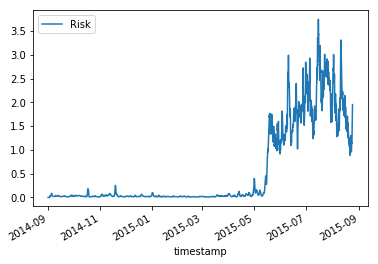

In [71]:
#Plot the risk predictions
prediction.set_index(pd.to_datetime(df['timestamp']), inplace=True)
prediction.plot()

## Find out which machine learning model did Darwin use:

In [72]:
status, model_type = ds.lookup_model_name(model)
print(model_type['description']['best_genome'])

AutoEncoderNet(
  (encoder): layer 1: Linear(in_features=45, out_features=11, bias=True, dropout=0.50, activation=relu)
  layer 2: Linear(in_features=11, out_features=45, bias=True, dropout=0.50, activation=identity)
)
